
# Differential Evolution

In this tutorial, you will learn how to optimize PyRates models via the
[differential evolution](https://en.wikipedia.org/wiki/Differential_evolution) strategy introduced in [1]_.
It will be based on the same model and the same parameter as the single parameter grid search example. So it will be
worthwhile to first have a look at that example, before proceeding.

Shortly, we will use the Jansen-Rit model (check out the model introduction for the Jansen-Rit model, to learn
about the mathematics behind the model and about its implementation in PyRates) [2]_.
We will perform a 1D evolutionary optimization over its connectivity scaling parameter $C$. This parameter scales
all synaptic strengths in the Jansen-Rit neural mass model and has a critical influence on its behavior [2]_.

The general idea behind evolutionary model optimization strategies is to optimize a set of model parameters with
respect to some objective function that defines the fitness of a certain model parametrization. Initially, a number of
different model parametrizations are sampled from a defined parameter space. Then, the iterative optimization starts.
At each iteration of the optimization algorithm, the following two steps are performed:

    1. The objective function is evaluated for each parametrization, resulting in a fitness value for each model
       parametrization
    2. The fitness values are used to sample new model parametrizations, mutate the old parametrizations, or create
       new parametrizations via combinations of the old parametrizations

These iterations are then repeated until a fitness criterion is reached. The exact functional relationships that are
used to translate fitness values and old parametrizations into new parametrizations depend on the type of evolutionary
model optimization strategy that is used. For a summary of differential evolution, have a look at
[this article](https://en.wikipedia.org/wiki/Differential_evolution). Below, we show how PyRates can be used in
combination with :code:`scipy.optimize.differential_evolution` to perform such parameter optimizations.

**References**

.. [1] R. Storn and K. Price (1997) *Differential Evolution - a Simple and Efficient Heuristic for Global Optimization
       over Continuous Spaces.* Journal of Global Optimization, 11: 341-359.

.. [2] B.H. Jansen & V.G. Rit (1995) *Electroencephalogram and visual evoked potential generation in a mathematical
       model of coupled cortical columns.* Biological Cybernetics, 73(4): 357-366.

.. [3] P. Virtanen, R. Gommers et al. (2020) *SciPy 1.0: fundamental algorithms for scientific computing in Python.*
       Nature Methods, 17: 261-272. https://doi.org/10.1038/s41592-019-0686-2.


First, let's import the :code:`differential_evolution` function from scipy together with other essential packages



In [1]:
from scipy.optimize import differential_evolution
from pyrates.frontend import CircuitTemplate
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Definition of the optimization details

(1) To optimize our parameter $C$, we will have to define the parameter boundaries within which the optimization
should be performed:



In [2]:
boundaries = (30.0, 300.0)

(2) Furthermore, we need to define the model and the model parameter that the $C$ refers to:



In [3]:
model_template = "model_templates.neural_mass_models.jansenrit.JRC2"
model_param = 'jrc/jrc_op/c'

(3) Finally, we have to define the objective function that should be optimized. This objective function always needs
to calculate a scalar fitness, based on model output. Thus, we first define the model output:



In [4]:
output = {'V_pce': 'jrc/jrc_op/V_e', 'V_pci': 'jrc/jrc_op/V_i'}

...and then the objective function:



In [5]:
def loss(data, min_amp=6e-3, max_amp=10e-3):
    """Calculates the difference between the value range in the data and the
    range defined by min_amp and max_amp.
    """

    # calculate the membrane potential of the PC population
    data = data.loc[:, 'V_pce'] - data.loc[:, 'V_pci']

    # calculate the difference between the membrane potential range
    # of the model and the target membrane potential range
    data_bounds = np.asarray([np.min(data), np.max(data)]).squeeze()
    target_bounds = np.asarray([min_amp, max_amp])
    diff = data_bounds - target_bounds

    # return the sum of the squared errors
    return diff @ diff.T

The value of this loss function depends on the minimum and the maximum value of the average membrane potential of the
pyramidal cell population of the Jansen-Rit model [1]_. Depending on the :code:`min_amp` and :code:`max_amp`
arguments of that function, the differential evolution algorithm should optimize the parameter $C$ of our model
such that the minimum and maximum membrane potential fluctuations of the PC population are as close to those values
as possible. Therefore, this function should suffice to find model parametrizations that express oscillatory behavior
with different oscillation amplitudes or non-oscillatory behavior.

As a final preparation, we need to define a function that takes a single value of $C$ as an argument, calculates
the model activity, and returns the loss for that particular parametrization:



In [6]:
def eval_param(value, T, dt, kwargs):

    # load template and update parameter value
    jrc = CircuitTemplate.from_yaml(model_template)
    jrc.update_var({model_param: value})

    # perform simulation
    data = jrc.run(outputs=output, simulation_time=T, step_size=dt, clear=True, verbose=False, **kwargs)

    # calculate and return loss
    return loss(data)

## Step 2: Performing the model optimization

Now that we have prepared everything to start the optimization, we can use
:code:`scipy.optimize.differential_evolution` to optimize our parameter of interest:



In [7]:
# simulation settings
T = 5.0
dt = 1e-4
kwargs = {'sampling_step_size': 1e-3, 'solver': 'scipy', 'backend': 'default', 'cutoff': 2.0}

# perform optimization
results = differential_evolution(eval_param, bounds=[boundaries], args=(T, dt, kwargs), strategy='randtobest1bin', maxiter=100, popsize=10, tol=1e-4)

The return value of the :code:`differential_evolution` function contains the winning parameter set and its loss
function value. Let's check out, whether this model parameter indeed produces the behavior we optimized for:



C = [136.39609917]
Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 2.5293499138206244s.


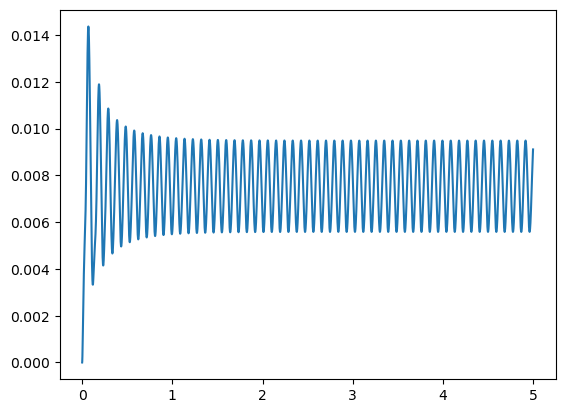

In [8]:
# check out final value of C
c = results.x
print(f'C = {c}')

# calculate dynamics of the JRC for C
jrc = CircuitTemplate.from_yaml(model_template)
jrc = jrc.update_var(node_vars={model_param: c})
kwargs.pop('cutoff')
results = jrc.run(simulation_time=T, step_size=dt, outputs=output, clear=True, **kwargs)

# visualization of the JRC dynamics
data = results['V_pce'] - results['V_pci']
plt.plot(data)
plt.show()

As can be seen, the model shows oscillatory behavior with minimum and maximum membrane potential amplitudes that
are close to our target values of 6.0 and 10.0 mV.

